# Coding Drill 03

## 1. Target

- Reduce number of parameters < 10K, trying to achieve accuracy within 15 EPOCHs
- Since we are reducing the parameters, there might be accuracy reduction
- Try improving based on data and by adjusting available layers


## Key Updates

- Data
  - Enabled data-trasnforms for training (normalized them) 
  - Enabled random rotations so that model learns better ( -10deg to +10 deg)
    - This could be  observed from data. So use in training

- Model: On top of CodingDrill_02, did the following
  - Tried adding additional layer to improve accuracy: Accuracy dropped

- Training
 - Lets start with 15 EPOCHs
 - Has LR scheduler

## 2. Result

- Params: `9,707`
- Train Accuracy: `99.8%`
- Test Accuracy : `99.1%`

## 3. Analysis

- The parameters have reduced < 10K 
- Tried adding additional layer to improve accuracy => Accuracy dropped
- Reduced droppout to 0.05 => Improved accuracy difference and test accuracy
- Augmented data from -10 to 10deg
- test accuracy is consistent in the last few epochs
- This improve accuracy from 99.1% to 99.25%



# Import Libraries

In [85]:
# import all the required torch functions
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


# Include Data Transformations

- We first start with defining our data transformations.
- We need to think what our data is and how can we augment it to represent  represent correctly which it might not see otherwise. 

In [86]:
# Train Phase transformations
train_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                            # Note the difference between (0.1307) and (0.1307,)
                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])

# Dataset and Creating Train/Test Split

In [87]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Check for GPU availability

In [88]:
SEED = 1

# CUDA? Check for GPU availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Setup Seed, for reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders

In [89]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

# The Model

- Let's start with model from where we achieved < 20K params (Earlier assignment S3) 

In [90]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
              
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)          
        x = self.convblock7(x)            

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [91]:
!pip install torchsummary
from torchsummary import summary

# Once we have GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).
# test if PyTorch has access to a GPU
use_cuda = torch.cuda.is_available()

# if GPU is availble use it, if not use CPU. allocate device and assign n/w to it
device = torch.device("cuda" if use_cuda else "cpu")

# configure the model to be loaded on the device decided above.
model = Net().to(device)

# input image size: 28x28, Input_channels: 1
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 30, 24, 24]           3,780
              ReLU-6           [-1, 30, 24, 24]               0
       BatchNorm2d-7           [-1, 30, 24, 24]              60
           Dropout-8           [-1, 30, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             300
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
    

# Training and Testing

- Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 
- Let's write train and test functions

In [92]:
# Tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  
  model.train() # set the model with training mode (this is the default mode)

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init. 
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict. 
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return 100. * correct / len(test_loader.dataset)


In [93]:
from torch.optim.lr_scheduler import StepLR

# move the model to the required device, GPU if available, if not on CPU.
model = Net().to(device)

# create an optimizer (SGD) with required parameters, 
# model.parameters() - these are the model parameters to optimize, 
# learning-rate lr=0.01 and momentum-0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Configure epochs to train for
EPOCHS = 15

prev_train_acc = -1
prev_test_acc = -1
train_accuracy = 0
test_accuracy = 0

# run single epoch as of now.
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}')

    # train the model loaded on the device with the required optimizer
    train_accuracy = train(model, device, train_loader, optimizer, epoch)

    # set to the next lr params
    scheduler.step()

    # we need to evaluate on test data
    test_accuracy = test(model, device, test_loader)


    # check difference from previous accuracies for better understanding
    if -1 == prev_train_acc:
      prev_train_acc = train_accuracy
    if -1 == prev_test_acc:
      prev_test_acc = test_accuracy

    print(f'train_acc_diff: {train_accuracy - prev_train_acc:.3f} test_acc_diff: {test_accuracy - prev_test_acc:.3f} test_train_diff: {test_accuracy - train_accuracy:.3f}\n')
    prev_train_acc = train_accuracy
    prev_test_acc = test_accuracy


Epoch: 1


Loss=0.13642702996730804 Batch_id=468 Accuracy=88.15: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]



Test set: Average loss: 0.0939, Accuracy: 9736/10000 (97.36%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 9.207

Epoch: 2


Loss=0.07948734611272812 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]



Test set: Average loss: 0.0503, Accuracy: 9861/10000 (98.61%)

train_acc_diff: 9.215 test_acc_diff: 1.250 test_train_diff: 1.242

Epoch: 3


Loss=0.08768296241760254 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0569, Accuracy: 9829/10000 (98.29%)

train_acc_diff: 0.507 test_acc_diff: -0.320 test_train_diff: 0.415

Epoch: 4


Loss=0.015283248387277126 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]



Test set: Average loss: 0.0376, Accuracy: 9884/10000 (98.84%)

train_acc_diff: 0.287 test_acc_diff: 0.550 test_train_diff: 0.678

Epoch: 5


Loss=0.07165809720754623 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0370, Accuracy: 9890/10000 (98.90%)

train_acc_diff: 0.243 test_acc_diff: 0.060 test_train_diff: 0.495

Epoch: 6


Loss=0.043894603848457336 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]



Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)

train_acc_diff: 0.008 test_acc_diff: 0.180 test_train_diff: 0.667

Epoch: 7


Loss=0.13364438712596893 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

train_acc_diff: 0.303 test_acc_diff: 0.170 test_train_diff: 0.533

Epoch: 8


Loss=0.013303210027515888 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:19<00:00, 23.77it/s]



Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

train_acc_diff: 0.132 test_acc_diff: 0.040 test_train_diff: 0.442

Epoch: 9


Loss=0.033122144639492035 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]



Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

train_acc_diff: -0.003 test_acc_diff: -0.030 test_train_diff: 0.415

Epoch: 10


Loss=0.012786831706762314 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]



Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

train_acc_diff: 0.023 test_acc_diff: -0.020 test_train_diff: 0.372

Epoch: 11


Loss=0.009499959647655487 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

train_acc_diff: 0.002 test_acc_diff: 0.020 test_train_diff: 0.390

Epoch: 12


Loss=0.057077229022979736 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]



Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

train_acc_diff: 0.007 test_acc_diff: -0.010 test_train_diff: 0.373

Epoch: 13


Loss=0.08159735053777695 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

train_acc_diff: 0.005 test_acc_diff: 0.020 test_train_diff: 0.388

Epoch: 14


Loss=0.04119599610567093 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.22%)

train_acc_diff: 0.117 test_acc_diff: -0.050 test_train_diff: 0.222

Epoch: 15


Loss=0.024118224158883095 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

train_acc_diff: -0.062 test_acc_diff: 0.030 test_train_diff: 0.313



# Move tesnors to numpy as required

- train_losses is a list, but train_losses[i] is a tensor
- all others are numpy

## APIs to use

- To go from np.array to cpu Tensor    => torch.from_numpy().
- To go from cpu Tensor to gpu Tensor  => .cuda()
- To go from a Tensor that requires_grad to one that does not => .detach() 
- To go from a gpu Tensor to cpu Tensor => .cpu()
- To gp from a cpu Tensor to np.array   => .numpy()

In [94]:
# type(train_losses), type(train_losses[0])

for i, loss in enumerate(train_losses):
  train_losses[i] = loss.detach().cpu().numpy()

# Plot the model's learning progress

- Plot training and test accuracies

Text(0.5, 1.0, 'Test Accuracy')

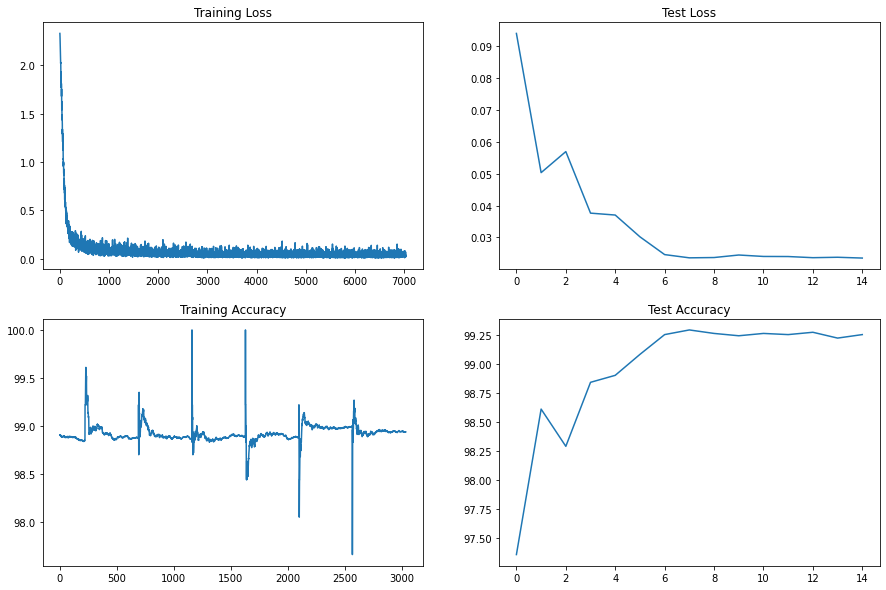

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")